In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

from CWScopeTesting import *
from WPI_SCA_LIBRARY.FileFormat import *
from WPI_SCA_LIBRARY.Metrics import *

# init test scope object
scope = CWScopeTesting()

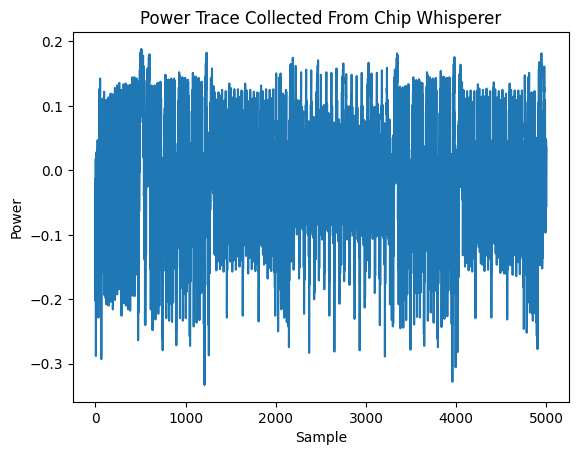

In [52]:
# Captures a single power trace and plots it
scope.capture_one_trace()

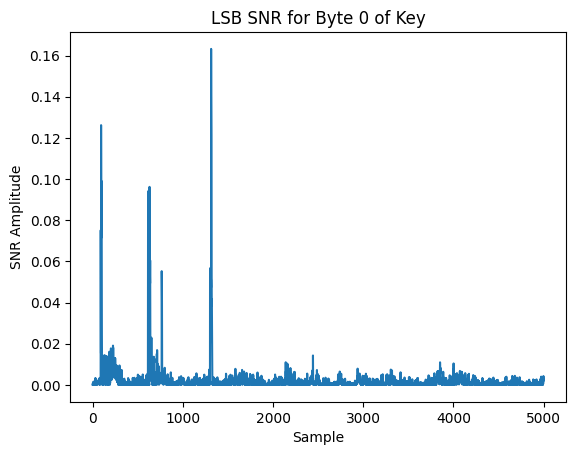

In [61]:
# read in the stored trace data from the HDF5 file
num_traces = 1000
scope.cw_scope.cw_to_hdf5("test_file.hdf5", "test_experiment", num_traces, True, False) # fixed key, random pt

with h5py.File('test_file.hdf5', "a") as data_file:
    # load in file
    fileClass = HDF5FileClass('test_file.hdf5', fileInputType="existing", data_file=data_file)
    exp = fileClass.experiments['test_experiment']
    
    # load in datasets
    traces = exp.dataset["traces"]
    plaintext = exp.dataset["plaintext"]
    keys = exp.dataset["keys"]
    
    # we are going to perform an SNR calculation on the measured data therefore we need to calculate some labels
    exp.addDataset("labels", (num_traces, scope.cw_scope.scope.adc.samples), definition="Labels for SNR", dtype='int8')
    labelDataset = exp.dataset["labels"]
    
    # we generated the traces with a fixed key so the key is the same for all traces
    key = keys.readData(0)
    target_byte = 0
    correct_key_byte = key[target_byte]
    
    # generate intermediate values from sbox lut
    for i in range(num_traces):
        label = sbox_lut(correct_key_byte ^ int(plaintext.readData(i)[target_byte]) & 0b1)
        labelDataset.addData(i, label)
    
    # obtain traces and labels
    traces = traces.readData(range(num_traces))
    labels = labelDataset.readData(range(num_traces))
    
    # find unique labels
    labelsUnique = np.unique(labels)
    
    # initialize the dictionary
    sortedLabels = {}
    for i in labelsUnique:
        sortedLabels[i] = []

    # add traces to labels
    for index, label in enumerate(labels):
        sortedLabels[label[0]].append(traces[index])
        
    # snr calculation    
    snr = signal_to_noise_ratio(sortedLabels)
    
    # plot the SNR
    plt.plot(snr)
    plt.title("LSB SNR for Byte 0 of Key")
    plt.xlabel("Sample")
    plt.ylabel("SNR Amplitude")   

In [62]:
# Disconnect Scope remove test file
os.remove("test_file.hdf5")
scope.cw_scope.disconnect()